Ran `CountTopMarkets` scala script for 08/19 - 09/06. Clean up code from 08a, and plot counts vs time

In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

In [2]:
# for notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

In [3]:
APP_NAME = "KF-TopMarketsAnalysis"

# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.app.name", APP_NAME),
#         ("spark.master","yarn"),
        ("spark.driver.memory","10g"),
#         ("spark.executor.memory", "10g"),
#         ("spark.executor.instances", 5),
#         ("spark.executor.cores", "5"),
#         ('spark.sql.crossJoin.enabled', True),
#         ('spark.sql.shuffle.partitions', 8) 
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

In [4]:
spark.sparkContext.applicationId

'local-1662581918219'

# load data

In [5]:
inputPath = "/user/kendra.frederick/lookups/top_markets/top_10000/"

In [6]:
!hdfs dfs -ls $inputPath > temp.txt

In [8]:
with open('temp.txt') as file:
    tempList = file.readlines()[1:]

pathList = [x.split(" ")[-1].strip() for x in tempList]
results_dict = {}

for path in pathList:
    date = path.split("/")[-1].rstrip(".csv")
    print(f"Processing {date}")
    df = spark.read.csv(path, header=True, inferSchema=True)
    temp = df.select('market', 'num_unique_shops').collect()
    market_dict = {x['market']: x['num_unique_shops'] for x in temp}
    results_dict[date] = market_dict

Processing 20220819
Processing 20220820
Processing 20220821
Processing 20220822
Processing 20220823
Processing 20220824
Processing 20220825
Processing 20220826
Processing 20220827
Processing 20220828
Processing 20220829
Processing 20220830
Processing 20220831
Processing 20220901
Processing 20220902
Processing 20220903
Processing 20220904
Processing 20220905
Processing 20220906


In [9]:
from collections import defaultdict, Counter

In [10]:
# marketCounter = defaultdict(int)
marketCounter = Counter()
shopCounter = Counter()
for key, valDict in results_dict.items():
    marketCounter += Counter(valDict.keys())
    shopCounter += Counter(valDict)

In [11]:
dfShop = pd.DataFrame.from_dict(shopCounter, orient='index', columns=['sumShopCounts'])
dfDays = pd.DataFrame.from_dict(marketCounter, orient='index', columns=['numDays'])

dfSummary = dfShop.join(dfDays)
dfSummary.sort_values(by='sumShopCounts', inplace=True, ascending=False)
dfSummary['avgCounts'] = dfSummary['sumShopCounts'] / dfSummary['numDays']

dfSummary['rankSumCount'] = dfSummary['sumShopCounts'].rank(ascending=False)
dfSummary['rankAvgCount'] = dfSummary['avgCounts'].rank(ascending=False)

In [18]:
dfSummary.head(20)

,sumShopCounts,numDays,avgCounts,rankSumCount,rankAvgCount
DME-IST,18207752,19,958302.736842,1.0,1.0
VKO-IST,17371278,19,914277.789474,2.0,2.0
LHR-BKK,15574203,19,819694.894737,3.0,3.0
VKO-SAW,15167688,19,798299.368421,4.0,4.0
ICN-BKK,15041679,19,791667.315789,5.0,5.0
SIN-BKK,13734462,19,722866.421053,6.0,6.0
SVO-IST,12598152,19,663060.631579,7.0,7.0
BKK-ICN,11971504,19,630079.157895,8.0,8.0
DME-SAW,11683567,19,614924.578947,9.0,9.0
BKK-HKT,11428250,19,601486.842105,10.0,10.0


In [76]:
# top1000avg = list(dfSummary.sort_values(by='avgCounts', ascending=False)[:1000].index)
# diff = list(set(top1000sum) - set(top1000avg))
# dfSummary.loc[diff]

In [20]:
dfSummary.reset_index(inplace=True)
dfSummary.rename(columns={'index':'market'}, inplace=True)

In [92]:
# save local csv
# dfSummary[['market', 'sumShopCounts', 'numDays', 'rankSumCount']].to_csv('./output/top_markets_summary.csv', index=False)

In [19]:
top1000sum = list(dfSummary.sort_values(by='sumShopCounts', ascending=False)[:1000].index)

In [ ]:
# save to HDFS
topData = [(x,) for x in top1000sum]

sparkDfTop = spark.createDataFrame(topData, schema=T.StructType(
    [T.StructField("market_key", T.StringType(), nullable=False)]
                                  ))

In [45]:
# this was poorly named & located
# markets_path = "/user/kendra.frederick/shop_grid/markets.csv"
top_markets_path = "/user/kendra.frederick/lookups/top_markets/top_1000_markets.csv"
sparkDfTop.write.mode("overwrite").csv(top_markets_path, header=True)

# plots

Do average and sum of shop counts correlate?

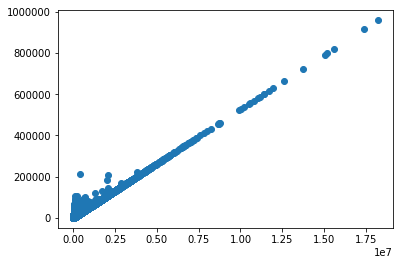

In [16]:
# dfSummary.plot('sumShopCounts', 'avgCounts')
plt.scatter(dfSummary['sumShopCounts'], dfSummary['avgCounts']);

In [22]:
np.corrcoef(dfSummary['sumShopCounts'], dfSummary['avgCounts'])

array([[1.        , 0.99291572],
       [0.99291572, 1.        ]])

For top markets, how do their counts vary over time?

## reprocess data

Previously:

    pathList = [x.split(" ")[-1].strip() for x in tempList]
    results_dict = {}

    for path in pathList:
        date = path.split("/")[-1].rstrip(".csv")
        print(f"Processing {date}")
        df = spark.read.csv(path, header=True, inferSchema=True)
        temp = df.select('market', 'num_unique_shops').collect()
        market_dict = {x['market']: x['num_unique_shops'] for x in temp}
        results_dict[date] = market_dict

In [23]:
results_dict['20220820']

{'GMP-CJU': 137283,
 'LHR-JFK': 628631,
 'VKO-IST': 777737,
 'MEL-SYD': 306750,
 'VKO-AYT': 492316,
 'VKO-DLM': 129231,
 'VKO-BJV': 84237,
 'LHR-EWR': 582933,
 'SIN-BKK': 796047,
 'SYD-MEL': 275070,
 'JFK-LHR': 333800,
 'CDG-JFK': 346252,
 'LGA-YYZ': 184779,
 'BKK-HKT': 571472,
 'ICN-BKK': 787530,
 'HND-CTS': 92957,
 'EWR-YYZ': 164117,
 'BKK-SIN': 629082,
 'VKO-SAW': 663764,
 'JFK-LAX': 318183,
 'LAX-JFK': 336423,
 'CGH-SDU': 103730,
 'LHR-IST': 590848,
 'BKK-CNX': 545976,
 'SDU-CGH': 89181,
 'LHR-YYZ': 204930,
 'HND-FUK': 76294,
 'BKK-ICN': 643074,
 'JFK-MIA': 230442,
 'LHR-BKK': 858200,
 'YYZ-YVR': 171928,
 'EWR-LAX': 317826,
 'YYZ-LGA': 138509,
 'SGN-BKK': 374524,
 'LAX-EWR': 331510,
 'ORD-LGA': 129607,
 'EWR-LHR': 311870,
 'YYZ-EWR': 113666,
 'LHR-LAX': 203041,
 'LGA-ORD': 136333,
 'LGA-MIA': 224035,
 'LED-AYT': 93536,
 'MXP-JFK': 294440,
 'HND-OKA': 93475,
 'BNE-SYD': 160731,
 'HKT-BKK': 414113,
 'FUK-HND': 51355,
 'BOM-DEL': 196216,
 'CDG-YUL': 164494,
 'MNL-CEB': 104828,
 'SGN-H

In [ ]:


# for path in pathList:
#     date = path.split("/")[-1].rstrip(".csv")
#     print(f"Processing {date}")
#     df = spark.read.csv(path, header=True, inferSchema=True)
#     temp = df.select('market', 'num_unique_shops').collect()
#     market_dict = {x['market']: x['num_unique_shops'] for x in temp}
#     results_dict[date] = market_dict

In [29]:
data = []
for date_str, d in results_dict.items():
    date = datetime.datetime.strptime(date_str, '%Y%m%d')
    for m, c in d.items():
#         data.append([{'market': m, 'shop_count': c, 'date': date}])
        data.append([m, c, date])

In [30]:
data[:10]

[['GMP-CJU', 129610, datetime.datetime(2022, 8, 19, 0, 0)],
 ['VKO-IST', 855697, datetime.datetime(2022, 8, 19, 0, 0)],
 ['LHR-JFK', 651472, datetime.datetime(2022, 8, 19, 0, 0)],
 ['VKO-BJV', 95982, datetime.datetime(2022, 8, 19, 0, 0)],
 ['VKO-AYT', 550482, datetime.datetime(2022, 8, 19, 0, 0)],
 ['VKO-DLM', 144740, datetime.datetime(2022, 8, 19, 0, 0)],
 ['MEL-SYD', 273298, datetime.datetime(2022, 8, 19, 0, 0)],
 ['LHR-EWR', 610402, datetime.datetime(2022, 8, 19, 0, 0)],
 ['SYD-MEL', 245448, datetime.datetime(2022, 8, 19, 0, 0)],
 ['SIN-BKK', 662385, datetime.datetime(2022, 8, 19, 0, 0)]]

In [33]:
summary_df = pd.DataFrame(data, columns=['market', 'shop_count', 'date'])

In [34]:
summary_df.head()

,market,shop_count,date
0,GMP-CJU,129610,2022-08-19
1,VKO-IST,855697,2022-08-19
2,LHR-JFK,651472,2022-08-19
3,VKO-BJV,95982,2022-08-19
4,VKO-AYT,550482,2022-08-19


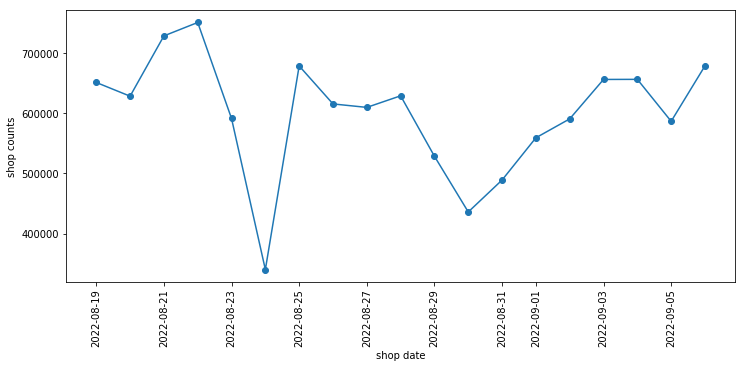

In [36]:
market = 'LHR-JFK'
mdf = summary_df[summary_df['market'] == market]

plt.figure(figsize=(12,5))
plt.plot_date(mdf['date'], mdf['shop_count'], 
              linestyle='-', marker='o'
             );
plt.xticks(rotation=90);
plt.ylabel('shop counts')
plt.xlabel('shop date');

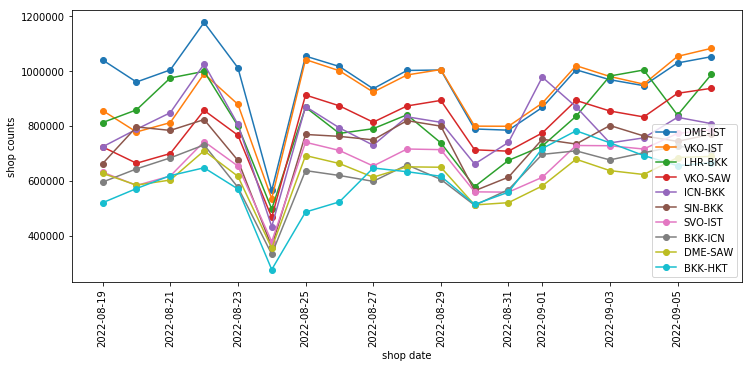

In [37]:
plt.figure(figsize=(12,5))

for market in top1000sum[:10]:

    mdf = summary_df[summary_df['market'] == market]

    plt.plot_date(mdf['date'], mdf['shop_count'], 
                  linestyle='-', marker='o',
                  label=market
                 );
    

plt.xticks(rotation=90);
plt.legend()
plt.ylabel('shop counts')
plt.xlabel('shop date');

Hmmm, wonder what happened on 8/24

Checked HDFS, and the 20220824 folder was missing a few hours. Perhaps data is missing even in the hour folders that are there

In [40]:
top10_df = summary_df[summary_df['market'].isin(top1000sum[:10])]
top10_pvt = top10_df.pivot(index='date', columns='market', values='shop_count')
corr = top10_pvt.corr()

Text(0.5, 1.0, 'Correlation between top 10 market volume')

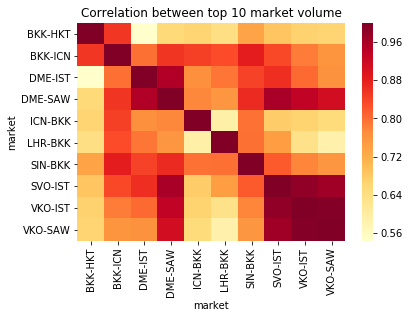

In [42]:
sns.heatmap(corr, cmap='YlOrRd');
plt.title("Correlation between top 10 market volume")

Would be interesting to plot these on a map